In [35]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML 
import itertools
import networkx as nx
import sys
import matplotlib.pyplot as plt
from textblob import TextBlob
from gender import gender_by_name

import warnings

In [26]:
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)
sep = '||||'

In [36]:
df = pd.read_csv('data/plays.csv')
df = df.set_index('Dataline')

df['ActSceneLine'] = df[['ActSceneLine']].applymap(lambda x: str(x))
df['Act'] = [ np.nan if line == np.nan else line.split('.')[0] for line in df.ActSceneLine]
df['Scene'] = [ np.nan if line == np.nan else line.split('.')[1] if len(line.split('.')) > 1 else np.nan for line in df.ActSceneLine]

df = df.dropna()

df['Act'] = [int(float(a)) for a in df['Act']]
df['Scene'] = [int(float(s)) for s in df['Scene']]
df['PlayerLinenumber'] = df[['PlayerLinenumber']].applymap(lambda x : round(x))
df['Player'] = [p.title() for p in df['Player']]
df['Play'] = [p.title() for p in df['Play']]

df['Code'] = ''
for i,r in df.iterrows():
    df.at[i, 'Code'] = r['Play'] + sep + '.'.join([str(r['Act']), str(r['Scene']), '{:03}'.format(r['PlayerLinenumber'])]) + sep + r['Player']

df[df.Play == 'Hamlet'].head()

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,Code
Dataline,,,,,,,,
32436,Hamlet,1,1.1.1,Bernardo,Who's there?,1,1,Hamlet||||1.1.001||||Bernardo
32437,Hamlet,2,1.1.2,Francisco,"Nay, answer me: stand, and unfold yourself.",1,1,Hamlet||||1.1.002||||Francisco
32438,Hamlet,3,1.1.3,Bernardo,Long live the king!,1,1,Hamlet||||1.1.003||||Bernardo
32439,Hamlet,4,1.1.4,Francisco,Bernardo?,1,1,Hamlet||||1.1.004||||Francisco
32440,Hamlet,5,1.1.5,Bernardo,He.,1,1,Hamlet||||1.1.005||||Bernardo


In [4]:
def make_relationship(a, b):
    return sep.join(sorted([a, b]))

In [34]:
m = df[['Code', 'PlayerLine']].groupby(['Code']).agg(lambda x: sep.join(x))
m = m.reset_index()

m['Play'] = [c.split(sep)[0] for c in m['Code']]
m['Address'] = [c.split(sep)[1] for c in m['Code']]
m['Act'] = [a.split('.')[0] for a in m['Address']]
m['Scene'] = [a.split('.')[1] for a in m['Address']]

m['Player'] = [c.split(sep)[2].title() for c in m['Code']]
m['Player'] = [' '.join(p.split()) for p in m['Player']]

m['Relationship'] = m['Target'] = ''

# fill targ 
for i, r in m.iterrows():
    line_number = int(r['Address'].split('.')[-1])
    is_first_line = line_number == 1
    is_last_line = i + 1 >= len(m) or m.at[i + 1, 'Act'] != r['Act'] or m.at[i + 1, 'Scene'] != r['Scene']
    
    if not is_first_line and not is_last_line:
        prev = m.at[i - 1, 'Player']
        next = m.at[i + 1, 'Player']
        r['Target'] = prev if prev == next else ''
        r['Relationship'] = '' if r['Target'] == '' else  make_relationship(r['Player'], r['Target'])
    
m = m.applymap(lambda x: x if x else np.NaN )
m

,Code,PlayerLine,Play,Address,Act,Scene,Player,Relationship,Target
0,A Comedy Of Errors||||1.1.001||||Aegeon,"Proceed, Solinus, to procure my fall||||And by...",A Comedy Of Errors,1.1.001,1,1,Aegeon,NaN,NaN
1,A Comedy Of Errors||||1.1.002||||Duke Solinus,"Merchant of Syracuse, plead no more,||||I am n...",A Comedy Of Errors,1.1.002,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
2,A Comedy Of Errors||||1.1.003||||Aegeon,"Yet this my comfort: when your words are done,...",A Comedy Of Errors,1.1.003,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
3,A Comedy Of Errors||||1.1.004||||Duke Solinus,"Well, Syracusian, say in brief the cause||||Wh...",A Comedy Of Errors,1.1.004,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
4,A Comedy Of Errors||||1.1.005||||Aegeon,A heavier task could not have been imposed||||...,A Comedy Of Errors,1.1.005,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
5,A Comedy Of Errors||||1.1.006||||Duke Solinus,"Nay, forward, old man, do not break off so,|||...",A Comedy Of Errors,1.1.006,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
6,A Comedy Of Errors||||1.1.007||||Aegeon,"O, had the gods done so, I had not now||||Wort...",A Comedy Of Errors,1.1.007,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
7,A Comedy Of Errors||||1.1.008||||Duke Solinus,"And for the sake of them thou sorrowest for,||...",A Comedy Of Errors,1.1.008,1,1,Duke Solinus,Aegeon||||Duke Solinus,Aegeon
8,A Comedy Of Errors||||1.1.009||||Aegeon,"My youngest boy, and yet my eldest care,||||At...",A Comedy Of Errors,1.1.009,1,1,Aegeon,Aegeon||||Duke Solinus,Duke Solinus
9,A Comedy Of Errors||||1.1.010||||Duke Solinus,"Hapless AEgeon, whom the fates have mark'd||||...",A Comedy Of Errors,1.1.010,1,1,Duke Solinus,NaN,NaN


In [6]:
def extract_matrix(play):
    players = sorted(m[m.Play == play].Player.unique())
    players = [p for p in players if p not in ['All', 'Prologue']]
    
    d = {player: [0] * len(players) for player in players}
    
    matrix = pd.DataFrame(data=d, index=players)
        
    for relationship in itertools.combinations(players, 2):
        r = make_relationship(relationship[0], relationship[1])
        cnt = len(m[m.Relationship == r])
        matrix.at[relationship[1], relationship[0]] = matrix.at[relationship[0], relationship[1]] = cnt    
    
    return matrix    

------------------

In [7]:
def personality(df, play, player):    
    player_df = df[(df.Play == play) & (df.Player == player)]                          
    sentiments = [TextBlob(line).sentiment for line in player_df.PlayerLine]
    polarities = [abs(s.polarity) for s in sentiments]
    subjectivities = [s.subjectivity for s in sentiments]
    percentage = len(df[(df.Play == play) & (df.Player == player)]) / len(df[df.Play == play])
    
    score = round(np.std(polarities) * np.std(subjectivities) * 100 / (percentage + 1), 2)
    return score       

In [66]:
def importance_of_edge(e, matrix):
    percentage = matrix.loc[e[0], e[1]]//(matrix.sum().sum()//100)
    return '★' * percentage

def plot_matrix(df, play):
    mat = extract_matrix(play)
    players = [c for c in list(mat.columns) if mat[c].sum() > 0]
    players = sorted(players, key=lambda p: personality(df=df, play=play, player=p))
        
    g = nx.Graph()
    g.add_nodes_from(players)
    
    for comb in itertools.combinations(players, 2):
        if mat.loc[comb[0], comb[1]] > 0:
            g.add_edge(comb[0], comb[1], weight=0.6)   
            
    pos = nx.spring_layout(g, k=1.9, scale=3)    
    
    _, __ = plt.subplots(1, 1, figsize=(24, 18))
    nx.draw_networkx_labels(g, pos, font_size=13, font_family='sans-serif')
        
    degrees = nx.degree(g)
    
    cs = range(len(g.nodes))
    
    nx.draw(g, pos, nodelist=[d[0] for d in degrees], node_size=[d[1] * 1500 for d in degrees], node_color=cs, cmap=plt.cm.coolwarm, style='dotted') 
    
    
    nx.draw_networkx_edge_labels(g, pos, edge_labels={e : importance_of_edge(e, mat) for e in g.edges if(gender_by_name(e[0]) != gender_by_name(e[1]))}, font_color='r', font_size=12)
    nx.draw_networkx_edge_labels(g, pos, edge_labels={e : importance_of_edge(e, mat) for e in g.edges if(gender_by_name(e[0]) == gender_by_name(e[1]))}, font_color='b', font_size=12)
    
    plt.axis('off')
    plt.title("Social network from '{}'".format(play) , fontsize=24, color='orange')
    plt.show()

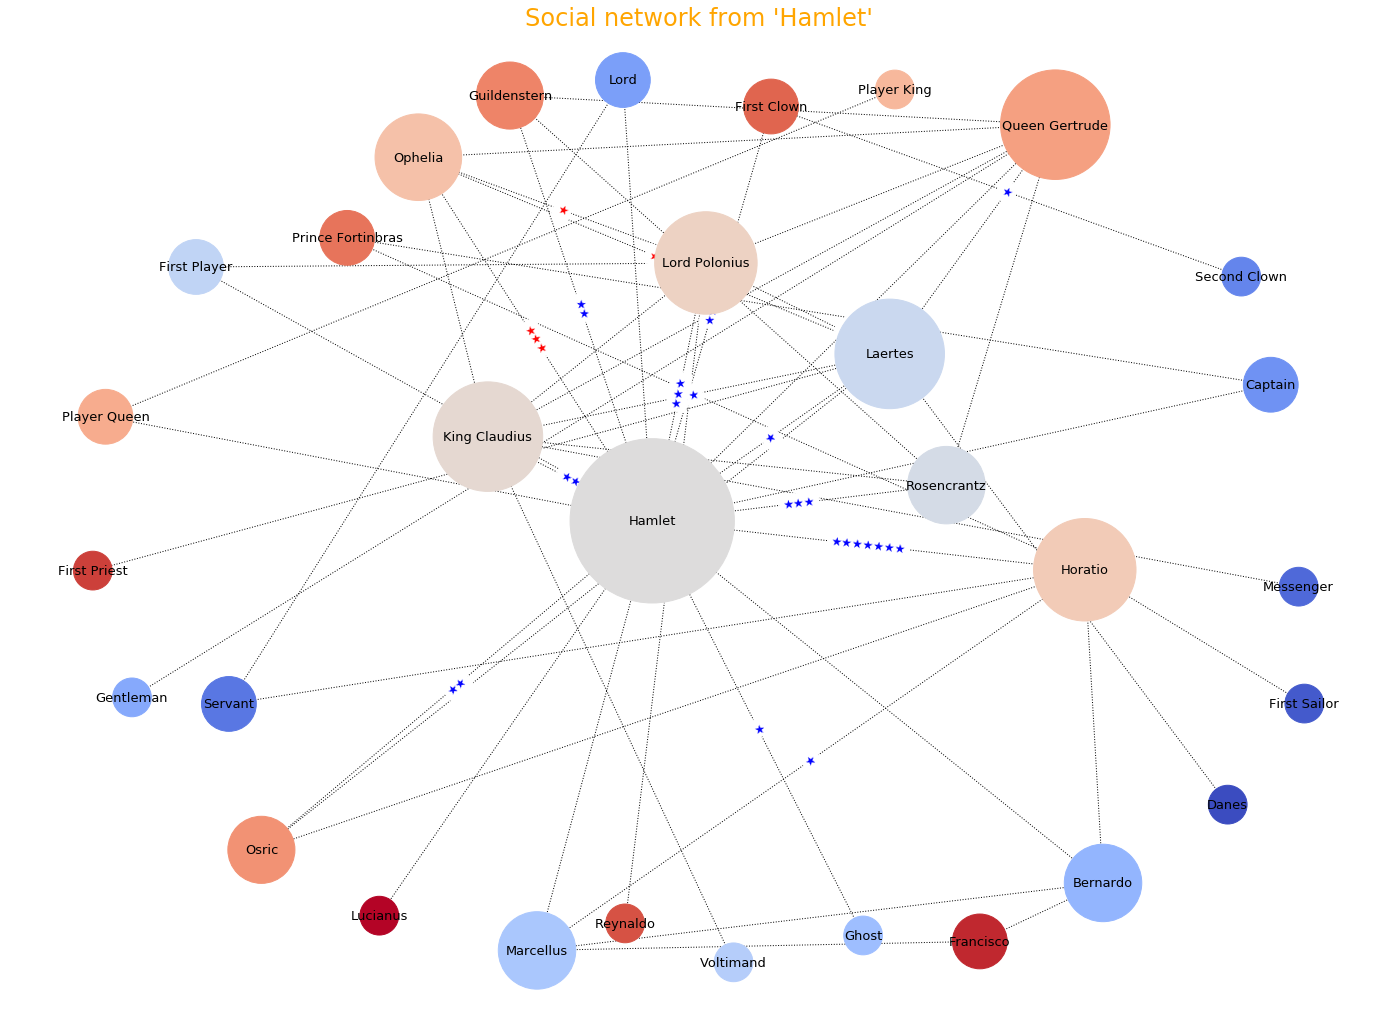

In [67]:
plot_matrix(df, 'Hamlet')

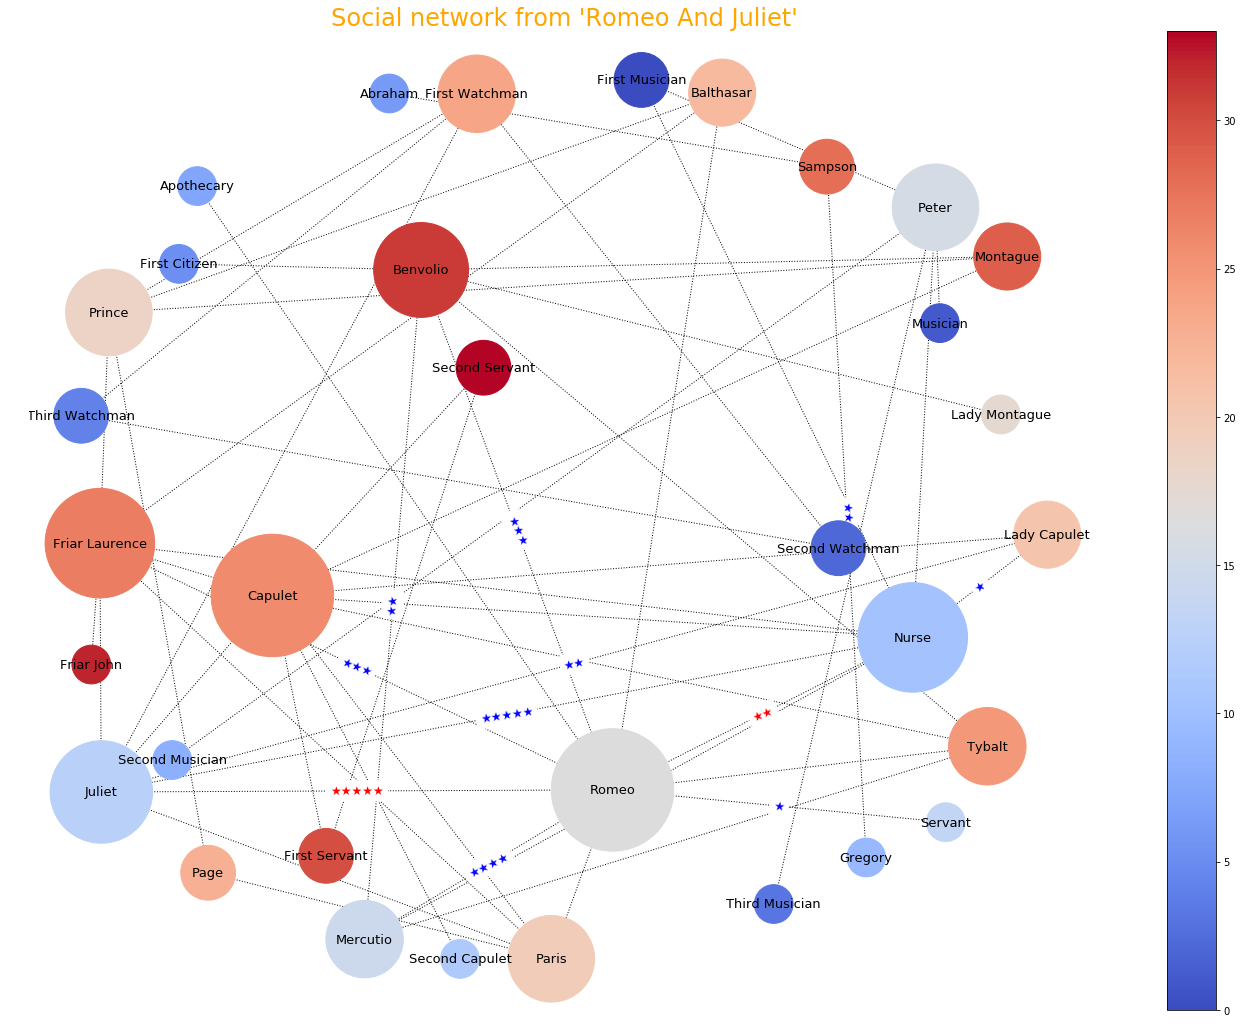

In [55]:
plot_matrix(df, 'Romeo And Juliet')